In [41]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

HW4-1

本题目使用的函数如下。

In [64]:
def Fre_filter(im_ary,H,fre_image=False):
    """
    频率域滤波5步骤
    input:
    im_ary:处理的图像
    H:频率域滤波器
    output:
    new_im:处理之后的图像
    
    """
    #第一步，填充图像（padding）
    M,N = im_ary.shape
    new_ary = np.zeros((2*M,2*N))
    #第二步，计算平移之后的DFT
    for i in range(M):
        for j in range(N):
            new_ary[i,j] = im_ary[i,j] * (-1)**(i+j) #平移
    F = cv2.dft(new_ary, flags=cv2.DFT_COMPLEX_OUTPUT)
    #第三步，在频率域与滤波器相乘
    G = F * H
    #画出频谱图
    if fre_image:
        #原图的频谱图
        f_dft = np.log(cv2.magnitude(F[:, :, 0], F[:, :, 1])+1)
        plt.subplot(121)
        plt.imshow(f_dft, cmap='gray')
        plt.axis("off")
        #频域操作结果的频谱图
        g_dft = np.log(cv2.magnitude(G[:, :, 0], G[:, :, 1])+1)
        plt.subplot(122)
        plt.imshow(g_dft, cmap='gray')
        plt.axis("off")
        plt.show()
    #第四步，计算傅里叶逆变换IDFT
    i_dft = cv2.idft(G)[:, :, 0]  #舍去虚部取实部
    result_ary = np.zeros((2*M,2*N))
    for i in range(M):
        for j in range(N):
            result_ary[i,j] = i_dft[i,j] * (-1)**(i+j) #平移
    #第五步，提取图像
    return result_ary[:M,:N]

In [58]:
def Smoothing(im_ary,ideal=False,Gaussian=False,D_0=60):
    """
    平滑操作
    input:
    im_ary:处理的图像
    ideal:是否使用理想低通滤波器
    Gaussian:是否使用高斯低通滤波器
    D_0:低通范围
    output:
    new_im:处理之后的图像
    """
    M,N = 2*im_ary.shape[0],2*im_ary.shape[1]
    if ideal == True:
        #生成理想低通滤波器
        f = lambda x, y: np.sqrt((x)**2 + (y)**2)
        crow, ccol = int(M / 2), int(N / 2) # 求得图像的中心点位置
        H = np.zeros((M, N, 2))
        for i in range(M):
            for j in range(N):
                distance = f(i-crow,j-ccol)
                if distance <= D_0:
                    H[i,j,0] = 1  #虚部为0
                else:
                    H[i,j,0] = 0
    elif Gaussian == True:
        #生成高斯低通滤波器
        sigma = D_0
        f = lambda x, y: np.exp(-(x**2+y**2)/(2*sigma**2))
        crow, ccol = int(M / 2), int(N / 2) # 求得图像的中心点位置
        H = np.zeros((M, N, 2))
        for i in range(M):
            for j in range(N):
                H[i,j,0] = f(float(i-crow),float(j-ccol))  #虚部为0
    return Fre_filter(im_ary,H,fre_image=True)

In [59]:
def Sharpening(im_ary,Laplace=False,High_boosting=False,D_0=60,k=9):
    """
    锐化操作
    input:
    im_ary:处理的图像
    Laplace:是否使用拉普拉斯算子
    Gaussian:是否使用高斯强调滤波
    D_0:高通范围
    k:High_boosting系数
    output:
    new_im:处理之后的图像
    """
    L = 256
    f_min = np.min(im_ary)
    f_max = np.max(im_ary)
    M,N = 2*im_ary.shape[0],2*im_ary.shape[1]
    H_1 = np.zeros((M, N, 2))  #实部全为1，虚部全为0
    for i in range(M):
        for j in range(N):
            H_1[i,j,0] = 1
    if Laplace == True:
        #生成Laplace算子
        crow, ccol = int(M / 2), int(N / 2) # 求得图像的中心点位置
        H_lap = np.zeros((M, N, 2))
        for i in range(M):
            for j in range(N):
                H_lap[i,j,0] = -4*(np.pi)**2*((i-crow)**2+(j-ccol)**2)
        #转为空间域（先对原始图像归一化）
        f_lap = Fre_filter(im_ary/f_max,H_lap)
        #锐化之后的图像
        new_ary = im_ary - f_lap/np.max(np.abs(f_lap))*(L-1)
                
    elif High_boosting == True:
        #生成高通高斯滤波
        sigma = D_0
        f = lambda x, y: np.exp(-(x**2+y**2)/(2*sigma**2))
        crow, ccol = int(M / 2), int(N / 2) # 求得图像的中心点位置
        H_lp = np.zeros((M, N, 2))
        for i in range(M):
            for j in range(N):
                H_lp[i,j,0] = f(float(i-crow),float(j-ccol))
        H_hp = H_1 - H_lp
        #转为空间域（先对原始图像归一化）
        g_mask = Fre_filter(im_ary/f_max,H_hp)
        #生成High_boosting滤波
        new_ary = im_ary + k*g_mask/np.max(np.abs(g_mask))*(L-1)
    #不能用简单的归一化，而是使用截断
    return truncation(new_ary,f_min,f_max)

In [81]:
def truncation(im_ary,f_min,f_max):
    """
    截断函数
    """
    L = 256
    m,n = im_ary.shape
    for i in range(m):
        for j in range(n):
            if im_ary[i,j] <= f_min:
                im_ary[i,j] = f_min
            if im_ary[i,j] >= f_max:
                im_ary[i,j] = f_max
    return im_ary

In [61]:
def normalize(im_ary):
    """
    归一化函数
    """
    L = 256
    i_max = np.max(im_ary)
    i_min = np.min(im_ary)
    new_ary = (im_ary - i_min)/(i_max-i_min)*(L-1)
    return new_ary

（1）低通平滑操作，并把算法应用与图片上，显示原图的频谱图、频域操作结果的频谱图，以及操作结果；

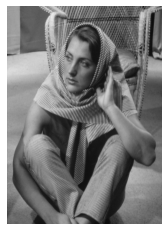

In [62]:
#读取图像
im = Image.open('lena.tif').convert('L')
im_ary = np.array(im, dtype='float32')
plt.imshow(im_ary, cmap='gray')
plt.axis("off")
plt.show()

首先使用理想低通滤波器，结果如下：

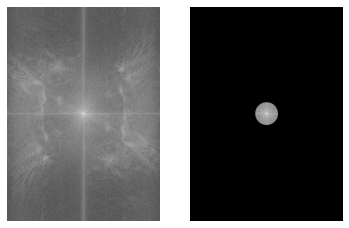

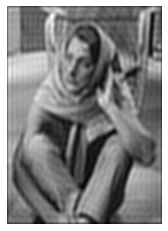

In [65]:
#平滑(理想滤波器)
new_ary1 = Smoothing(im_ary,ideal=True,Gaussian=False,D_0=60)
plt.imshow(normalize(new_ary1), cmap='gray')
plt.axis("off")
plt.show()

发现平滑结果图像中有振铃效果，改用高斯低通滤波器

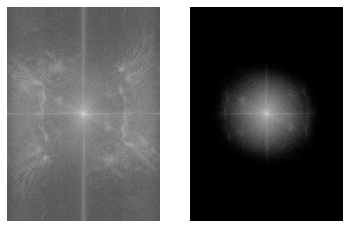

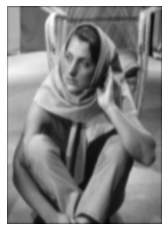

In [66]:
#平滑(高斯滤波器)
new_ary2 = Smoothing(im_ary,ideal=False,Gaussian=True,D_0=60)
plt.imshow(normalize(new_ary2), cmap='gray')
plt.axis("off")
plt.show()

没有振铃效果，且平滑效果良好。

（2）实现至少一种图像的锐化操作，该操作是基于频域操作的。

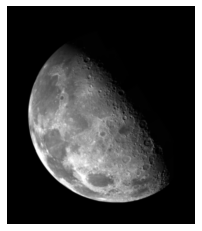

In [103]:
#读取图像
im = Image.open('blurry_moon.tif').convert('L')
im_ary = np.array(im, dtype='float32')
plt.imshow(im_ary, cmap='gray')
plt.axis("off")
plt.show()

实验中遇到几个问题：\
1）傅里叶反变换得到$▽^2f(x,y)$的值的数量级要比f大几个数量级，因此，存在比例缩放问题。\
2）叠加高频细节后的图g，改变了原始f的值域范围，并同样存在负值。如果对g简单使用归一化处理，将最小值映射为0，最大值映射为1，可能会改变整幅图像g的对比度，显示时看起来整个图将变暗（与输入图像f对比）。这并不是我们期望看到的结果。

解决方法：\
1）傅里叶变换前，对f先做归一化处理，使f的值的范围在[0,1]；把求得的Laplacian结果除以绝对值最大值max(abs($▽^2f(x,y)$))，使得其值控制在[-1,1]范围。这样二者具有了数值上的可比性。\
2）因f和$▽^2f(x,y)$的叠加结果可能超过[0,1]范围，强制类型转换或归一化到[0,1]，会使锐化结果整体变亮或变暗。有效的措施是利用原始图像f的实际灰度值范围[min(f)  max(f)]对锐化结果g进行标定，再次调整其灰度范围，使它保持与f基本一致。

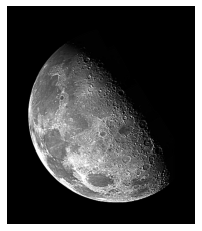

In [104]:
#锐化（Laplace算子）
new_ary3 = Sharpening(im_ary,Laplace=True,High_boosting=False,D_0=60,k=9)
plt.imshow(new_ary3, cmap='gray')
plt.axis("off")
plt.show()

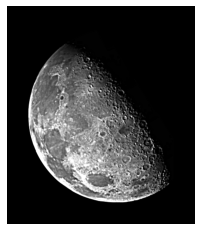

In [105]:
#锐化（High boosting方法 k=1时 即unsharp masking方法）
new_ary4 = Sharpening(im_ary,Laplace=False,High_boosting=True,D_0=60,k=1)
plt.imshow(new_ary4, cmap='gray')
plt.axis("off")
plt.show()

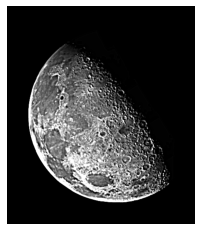

In [106]:
#锐化（High boosting方法）
new_ary4 = Sharpening(im_ary,Laplace=False,High_boosting=True,D_0=60,k=2)
plt.imshow(new_ary4, cmap='gray')
plt.axis("off")
plt.show()

HW4-2

针对对大脑、心脏图像（或其他多类图像），生成以下两种不同类型、不同强度的噪声，并使用生成的噪声污染图像，对比展示噪声污染前后的图像：

（1）生成白噪声；

In [73]:
def White_noise(shape,a):
    """
    生成白噪声
    input:
    shape:生成白噪声的图片大小
    a:白噪声在频率域的幅度
    """
    L = 256
    m,n = shape
    Wn = np.zeros((m,n,2))
    for i in range(m):
        for j in range(n):
            #随机生成白噪声在频率域中的相位
            theta = 2*np.pi*np.random.rand()
            e_real = a * np.cos(theta)
            e_imag = a * np.sin(theta)
            Wn[i,j,0] = e_real
            Wn[i,j,1] = e_imag
    Wn = cv2.idft(Wn)[:,:,0] #舍去虚部 只取实部
    #归一化后使其成为图像像素值量级
    noise = Wn/np.max(np.abs(Wn))*(L-1)
    noise = noise.astype(np.uint8)
    return noise

我们生成频率域中频谱值固定，但相位随机的白噪声。将噪声加到原图像后进行对比度拉伸处理。

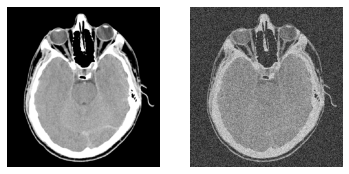

In [92]:
#读取图像
im = Image.open('headCT.tif').convert('L')
im_ary = np.array(im, dtype='float32')
L = 256
shape = im_ary.shape
noise = White_noise(shape,1)
new_ary = im_ary + noise
# 对比拉伸
new_ary = new_ary - np.full(new_ary.shape, np.min(new_ary))
new_ary = new_ary * (L-1)/ np.max(new_ary)
new_ary = new_ary.astype(np.uint8)

plt.subplot(121)
plt.imshow(im_ary, cmap='gray')
plt.axis("off")
plt.subplot(122)
plt.imshow(new_ary, cmap='gray')
plt.axis("off")
plt.show()

（2）生成其他一种噪声（如高斯、瑞利、椒盐噪声）

In [80]:
def Jiaoyan(shape,a,b,P_a,P_b):
    """
    生成椒盐噪声
    input:
    shape:生成椒盐噪声的图片大小
    a:盐像素值
    P_a:盐概率
    b:椒像素值
    P_b:椒概率
    """
    noise = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            if np.random.rand() <= P_a:
                noise[i,j] = a   #产生盐噪声
            elif np.random.rand() >= 1-P_b:
                noise[i,j] = b   #产生椒噪声
    return noise

我们生成椒盐噪声，将噪声加到原图像后进行截断处理。

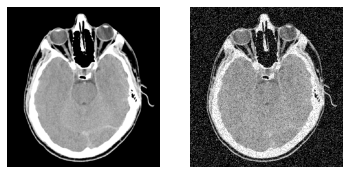

In [99]:
#读取图像
im = Image.open('headCT.tif').convert('L')
im_ary = np.array(im, dtype='float32')
L = 256
shape = im_ary.shape
noise = Jiaoyan(shape,255,-255,0.1,0.1)
new_ary = im_ary + noise
# 截断
new_ary = truncation(new_ary,0,255)

plt.subplot(121)
plt.imshow(im_ary, cmap='gray')
plt.axis("off")
plt.subplot(122)
plt.imshow(new_ary, cmap='gray')
plt.axis("off")
plt.show()

HW4-3

编程实现基于频域的选择滤波器方法，去除大脑CT体膜图像（Shepp-Logan）中的条纹

In [42]:
def alter_filter(shape,W,D_0,n):
    """
    生成带阻滤波器
    input:
    W:带宽
    D_0:带宽的径向中心
    n:布特沃斯滤波器的阶数
    """
    M,N = 2*shape[0],2*shape[1]
    #生成布特沃斯滤波器
    f_1 = lambda x, y: np.sqrt((x)**2 + (y)**2)
    f_2 = lambda t, n: 1/(1+np.power(t,2*n))
    crow, ccol = int(M / 2), int(N / 2) # 求得图像的中心点位置
    H = np.zeros((M, N, 2))
    for i in range(M):
        for j in range(N):
            D = f_1(i-crow,j-ccol)
            t = D*W/(D**2-D_0**2)
            H[i,j,0] = f_2(t,n)
    return H

In [185]:
def dai_filter(shape,d=10):
    """
    生成条形带阻滤波器
    input:
    W:带宽
    D_0:带宽的径向中心
    n:布特沃斯滤波器的阶数
    """
    M,N = 2*shape[0],2*shape[1]
    #生成条形带阻滤波器
    crow, ccol = int(M / 2), int(N / 2) # 求得图像的中心点位置
    H = np.zeros((M, N, 2))
    for i in range(M):
        for j in range(N):
            D = np.abs(i-crow)
            if 120-d<D<120+d:
                H[i,j,0] = 0
            elif 280-d<D<280+d:
                H[i,j,0] = 0
            elif 350-d<D<350+d:
                H[i,j,0] = 0
            elif 520-d<D<520+d:
                H[i,j,0] = 0
            elif 670-d<D<670+d:
                H[i,j,0] = 0
            else:
                H[i,j,0] = 1
    for i in range(M):
        for j in range(N):
            D_i = np.abs(i-crow)
            D = np.abs(j-ccol)
            if D_i>350:
                if 120-d<D<120+d:
                    H[i,j,0] = 0
                elif 280-d<D<280+d:
                    H[i,j,0] = 0
                elif 520-d<D<520+d:
                    H[i,j,0] = 0
                elif 670-d<D<670+d:
                    H[i,j,0] = 0
    return H

读取图像:

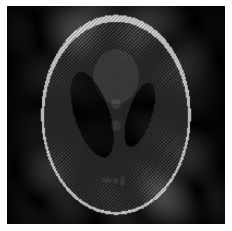

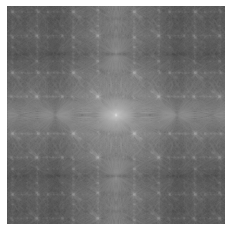

In [186]:
#读取图像
im = Image.open('photo3.PNG').convert('L')
im_ary = np.array(im, dtype='float32')
plt.imshow(im_ary, cmap='gray')
plt.axis("off")
plt.show()
#填充图像（padding）
M,N = im_ary.shape
new_ary = np.zeros((2*M,2*N))
#计算平移之后的DFT
for i in range(M):
    for j in range(N):
        new_ary[i,j] = im_ary[i,j] * (-1)**(i+j) #平移
F = cv2.dft(new_ary, flags=cv2.DFT_COMPLEX_OUTPUT)
#画出频谱图
f_dft = np.log(cv2.magnitude(F[:, :, 0], F[:, :, 1])+1)
plt.imshow(f_dft, cmap='gray')
plt.axis("off")
plt.show()

观察图像的频域图,发现有很多对称的高频亮点,猜想这些就是周期性噪声.

<ipython-input-184-06dc8d89f855>:18: RuntimeWarning: divide by zero encountered in double_scalars
  t = D*W/(D**2-D_0**2)


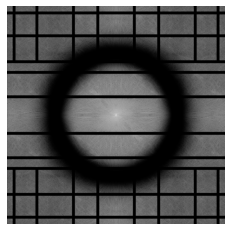

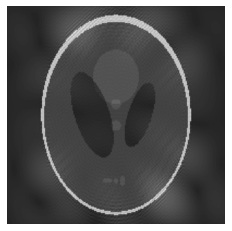

In [189]:
H_1 = dai_filter((M,N))
G_1 = H_1*F
H_2 = alter_filter((M,N),300,400,4)
G = H_2*G_1

g_dft = np.log(cv2.magnitude(G[:, :, 0], G[:, :, 1])+1)
plt.imshow(g_dft, cmap='gray')
plt.axis("off")
plt.show()

#第四步，计算傅里叶逆变换IDFT
i_dft = cv2.idft(G)[:, :, 0]  #舍去虚部取实部
result_ary = np.zeros((2*M,2*N))
for i in range(M):
    for j in range(N):
        result_ary[i,j] = i_dft[i,j] * (-1)**(i+j) #平移
plt.imshow(result_ary[:M,:N], cmap='gray')
plt.axis("off")
plt.show()

首先用条带状的陷波滤波器，将频域图中的高亮细线覆盖。\
然后使用布特沃斯带阻滤波器,将比较大块的亮度高的区域覆盖。\
处理之后的频率域结果和最终图像如图所示.\
发现虽然去除了某些噪声,但还有一些噪声没能完全去除.

我们尝试自己给图像增加一个噪声。

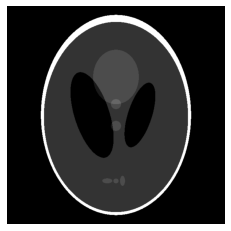

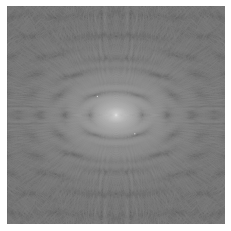

In [53]:
#读取图像
im = Image.open('photo4.tif').convert('L')
im_ary = np.array(im, dtype='float32')
plt.imshow(im_ary, cmap='gray')
plt.axis("off")
plt.show()
#填充图像（padding）
M,N = im_ary.shape
new_ary = np.zeros((2*M,2*N))
#计算平移之后的DFT
for i in range(M):
    for j in range(N):
        new_ary[i,j] = im_ary[i,j] * (-1)**(i+j) #平移
F = cv2.dft(new_ary, flags=cv2.DFT_COMPLEX_OUTPUT)
#增加噪声
F[M-105:M-100,N-105:N-100] = [F.max(),0]
F[M+101:M+106,N+101:N+106] = [F.max(),0]
#画出频谱图
f_dft = np.log(cv2.magnitude(F[:, :, 0], F[:, :, 1])+1)
plt.imshow(f_dft, cmap='gray')
plt.axis("off")
plt.show()

频谱图中出现两个对称的亮点。

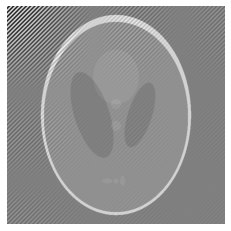

In [51]:
#计算傅里叶逆变换IDFT
i_dft = cv2.idft(F)[:, :, 0]  #舍去虚部取实部
result_ary = np.zeros((2*M,2*N))
for i in range(M):
    for j in range(N):
        result_ary[i,j] = i_dft[i,j] * (-1)**(i+j) #平移
plt.imshow(result_ary[:M,:N], cmap='gray')
plt.axis("off")
plt.show()

发现我们成功为图像增加了噪声。

接着我们使用布特沃斯带阻滤波器进行滤波，结果如下。

<ipython-input-42-06dc8d89f855>:18: RuntimeWarning: divide by zero encountered in double_scalars
  t = D*W/(D**2-D_0**2)


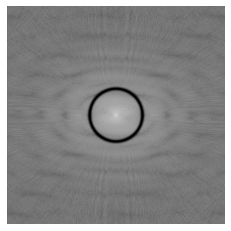

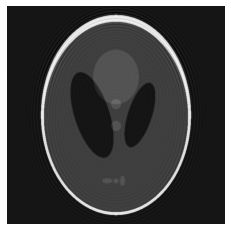

In [54]:
H = alter_filter((M,N),30,145,4)
G = H*F
g_dft = np.log(cv2.magnitude(G[:, :, 0], G[:, :, 1])+1)
plt.imshow(g_dft, cmap='gray')
plt.axis("off")
plt.show()

#计算傅里叶逆变换IDFT
i_dft = cv2.idft(G)[:, :, 0]  #舍去虚部取实部
result_ary = np.zeros((2*M,2*N))
for i in range(M):
    for j in range(N):
        result_ary[i,j] = i_dft[i,j] * (-1)**(i+j) #平移
plt.imshow(result_ary[:M,:N], cmap='gray')
plt.axis("off")
plt.show()

发现成功将噪声去除。

但我们发现刚才的噪声并不是周期性噪声，我们再增加一次周期性。

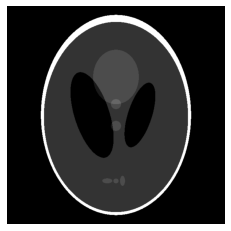

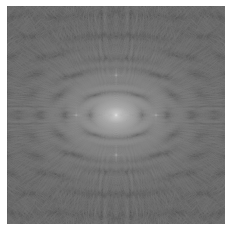

In [69]:
#读取图像
im = Image.open('photo4.tif').convert('L')
im_ary = np.array(im, dtype='float32')
plt.imshow(im_ary, cmap='gray')
plt.axis("off")
plt.show()
#填充图像（padding）
M,N = im_ary.shape
new_ary = np.zeros((2*M,2*N))
for i in range(M):
    for j in range(N):
        im_ary[i,j] = im_ary[i,j] + 20*np.sin(20*i)+20*np.sin(20*j) #增加噪声
#计算平移之后的DFT
for i in range(M):
    for j in range(N):
        new_ary[i,j] = im_ary[i,j] * (-1)**(i+j) #平移
F = cv2.dft(new_ary, flags=cv2.DFT_COMPLEX_OUTPUT)
#画出频谱图
f_dft = np.log(cv2.magnitude(F[:, :, 0], F[:, :, 1])+1)
plt.imshow(f_dft, cmap='gray')
plt.axis("off")
plt.show()

添加完噪声之后的图像如下图所示：

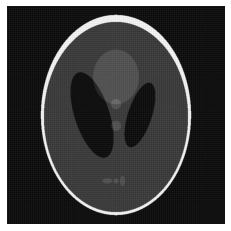

In [70]:
#计算傅里叶逆变换IDFT
i_dft = cv2.idft(F)[:, :, 0]  #舍去虚部取实部
result_ary = np.zeros((2*M,2*N))
for i in range(M):
    for j in range(N):
        result_ary[i,j] = i_dft[i,j] * (-1)**(i+j) #平移
plt.imshow(result_ary[:M,:N], cmap='gray')
plt.axis("off")
plt.show()

我们使用布特沃斯带阻滤波器进行滤波，结果如下。

<ipython-input-42-06dc8d89f855>:18: RuntimeWarning: divide by zero encountered in double_scalars
  t = D*W/(D**2-D_0**2)


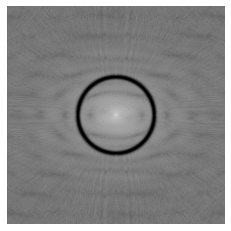

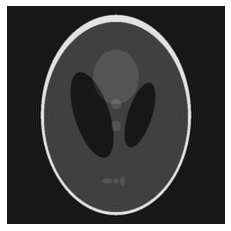

In [75]:
H = alter_filter((M,N),40,210,4)
G = H*F
g_dft = np.log(cv2.magnitude(G[:, :, 0], G[:, :, 1])+1)
plt.imshow(g_dft, cmap='gray')
plt.axis("off")
plt.show()

#计算傅里叶逆变换IDFT
i_dft = cv2.idft(G)[:, :, 0]  #舍去虚部取实部
result_ary = np.zeros((2*M,2*N))
for i in range(M):
    for j in range(N):
        result_ary[i,j] = i_dft[i,j] * (-1)**(i+j) #平移
plt.imshow(result_ary[:M,:N], cmap='gray')
plt.axis("off")
plt.show()

比较完美地去除了我们添加的周期性噪声。